License
MIT License

Copyright (c) 2021 jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# **importing libraries**

In [ ]:
from sklearn import tree                                  # sklearn tree model for decision trees
from sklearn.model_selection import train_test_split      # for partitioning data
from sklearn.model_selection import cross_val_score       # for cross validation
from sklearn.metrics import roc_auc_score, accuracy_score # to assess decision tree perforamce

# to upload local files
import io
from google.colab import files

import numpy as np                                   # array, vector, matrix calculations
import pandas as pd                                  # dataFrame handling

from matplotlib import pyplot as plt                 # plotting
import seaborn as sns                                # slightly better plotting

SEED = 12345                                         # ALWAYS use a random seed for better reproducibility



In [ ]:
# print version information
import sys
import sklearn
version = ".".join(map(str, sys.version_info[:3]))
print('Python version:', version)
print('sklearn version:', sklearn.__version__)

Python version: 3.10.12
sklearn version: 1.5.2


In [ ]:

 # special google collab command to upload a file from computer
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
type(uploaded)

dict

In [ ]:
uploaded.keys()

dict_keys(['gender_submission.csv', 'test.csv', 'train.csv'])

In [ ]:
# Load the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
Train_data = pd.read_csv(url)


# **EDA**

In [ ]:
Train_data.describe()
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


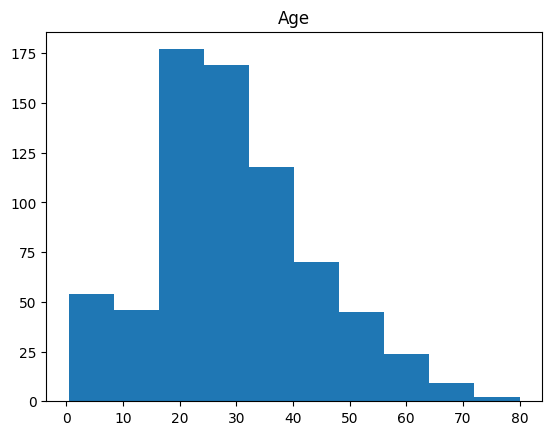

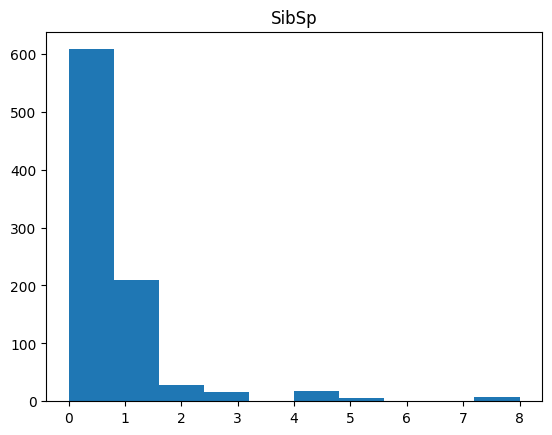

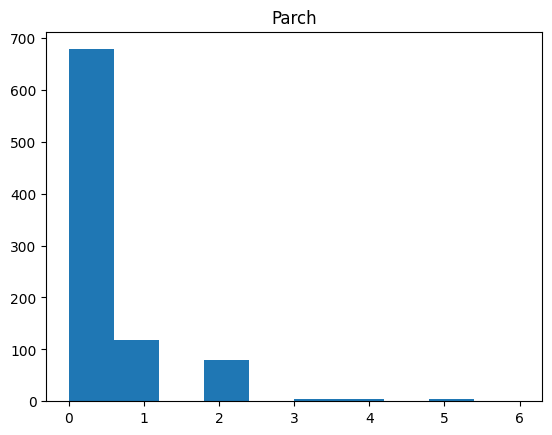

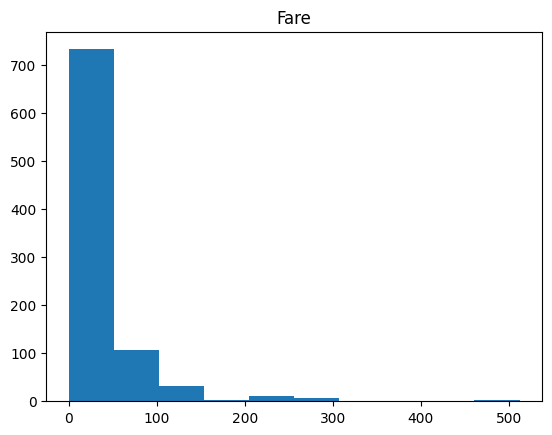

<Axes: xlabel='Pclass', ylabel='Fare'>

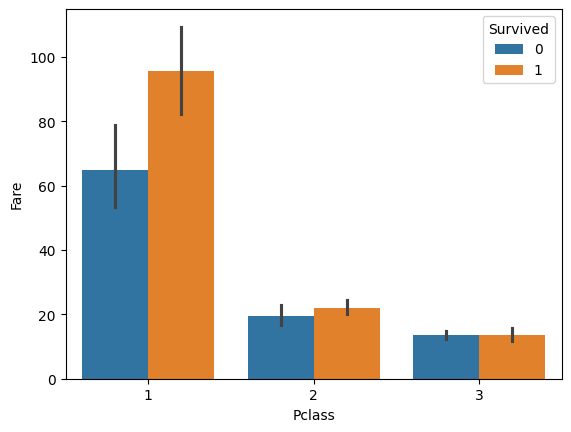

In [ ]:
df_num = Train_data[["Age", "SibSp", "Parch", "Fare"]]
df_cat = Train_data[["Survived", "Sex", "Cabin", "Embarked", "Ticket"]]

for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

sns.barplot(data=Train_data, x="Pclass", y="Fare", hue="Survived")

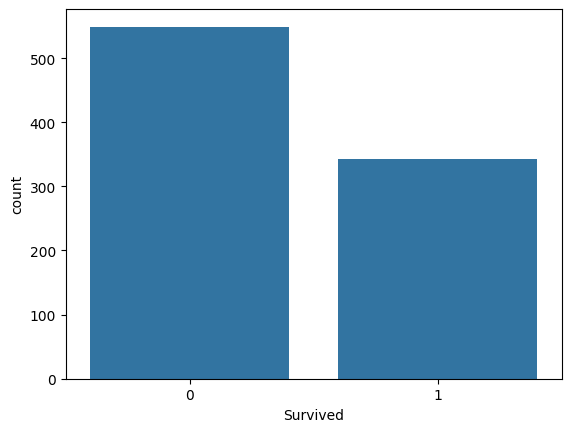

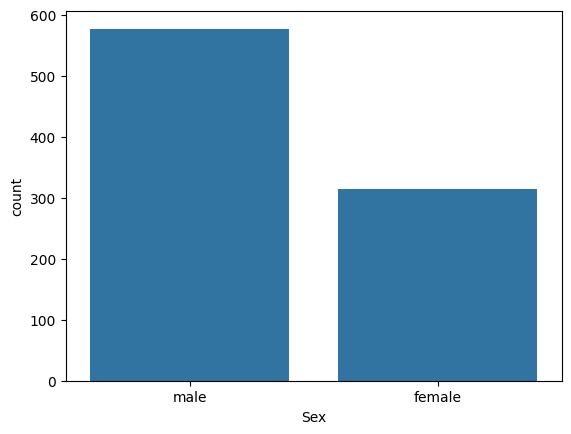

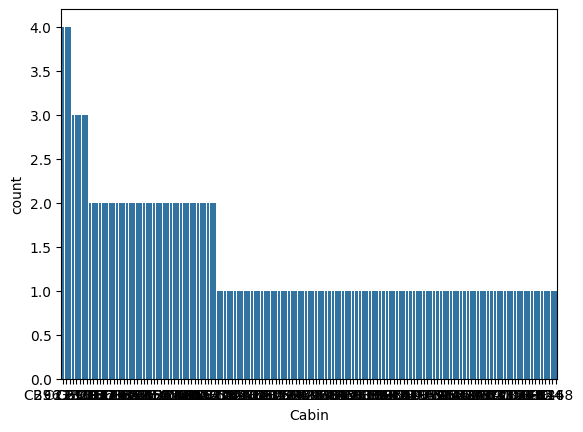

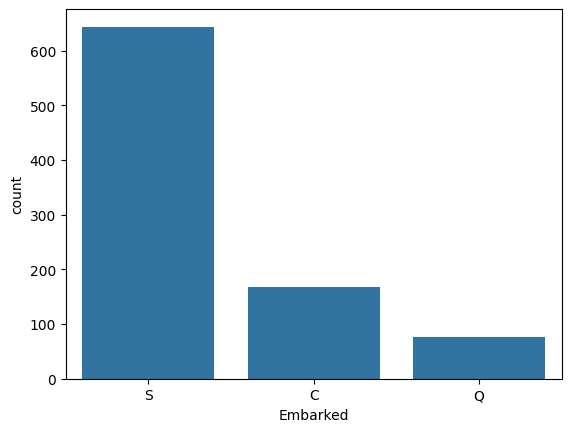

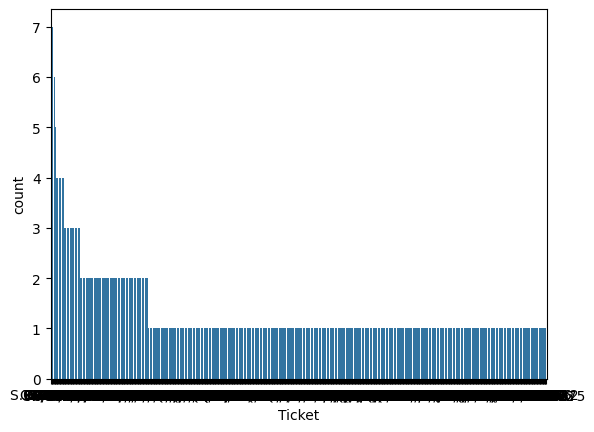

In [ ]:
pd.pivot_table(Train_data, index="Survived", values=["Age", "SibSp", "Parch", "Fare"])

for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index, y=df_cat[i].value_counts())
    plt.show()


In [ ]:
Train_data = Train_data.drop(columns=["PassengerId", "Cabin", "Name", "Ticket"])
Train_data["Age"] = Train_data["Age"].fillna(Train_data["Age"].mean())
Train_data["Embarked"] = Train_data["Embarked"].fillna(Train_data["Embarked"].mode()[0])
Train_data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


**Train decision Tree**

In [ ]:
from sklearn.preprocessing import LabelEncoder

cols = ["Sex", "Embarked"]
le = LabelEncoder()
for col in cols:
    Train_data[col] = le.fit_transform(Train_data[col])

Train_data.head()

X = Train_data.drop(columns=["Survived"], axis=1)
y = Train_data["Survived"]
Train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,2
1,1,1,0,38.000000,1,0,71.2833,0
2,1,3,0,26.000000,0,0,7.9250,2
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,2
887,1,1,0,19.000000,0,0,30.0000,2
888,0,3,0,29.699118,1,2,23.4500,2
889,1,1,1,26.000000,0,0,30.0000,0


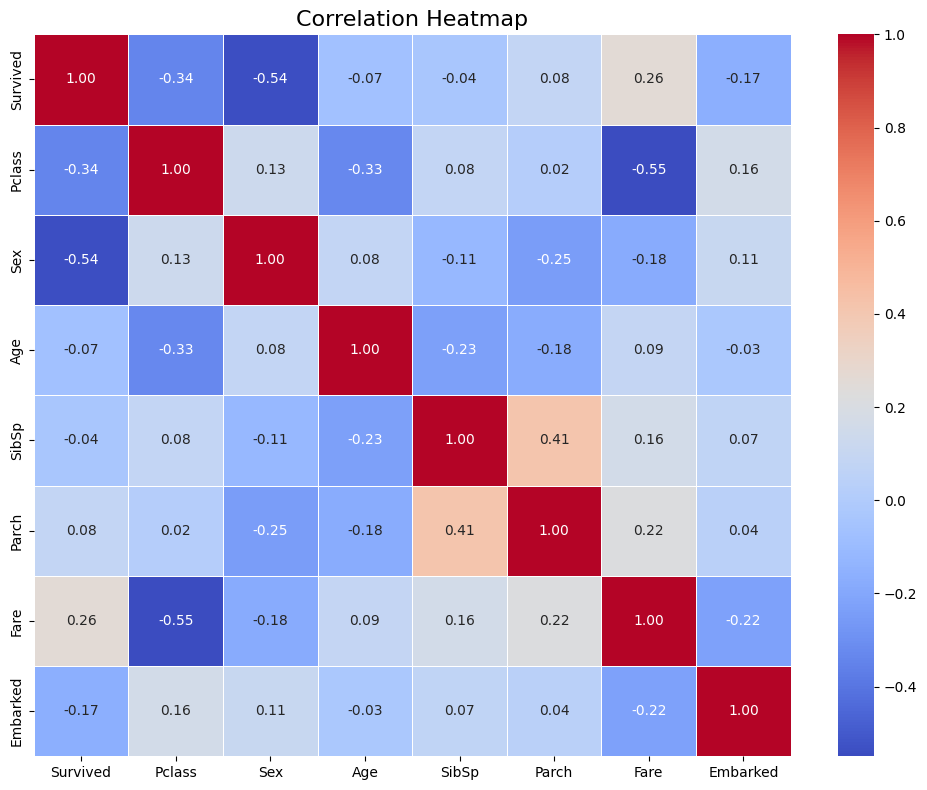

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numerical columns only
corr = Train_data.corr(numeric_only=True)  # Make sure Train_data is a pandas DataFrame

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Optional: Adjust the figure size as needed
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)

# Add title and adjust layout
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()

# Save the heatmap as an image
plt.savefig("Titanic-heatmap.png", dpi=300)  # Optional: Use higher DPI for better quality
plt.show()


In [ ]:
# Define features and target
X = Train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = Train_data['Survived']


In [ ]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Summarize
print('Training data: %i rows and %i columns' % (X_train.shape[0], X_train.shape[1]))
print('Validation data: %i rows and %i columns' % (X_val.shape[0], X_val.shape[1]))
print('Testing data: %i rows and %i columns' % (X_test.shape[0], X_test.shape[1]))


Training data: 623 rows and 7 columns
Validation data: 134 rows and 7 columns
Testing data: 134 rows and 7 columns


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

# Function to train decision tree with early stopping based on validation AUC
def train_decision_tree(X_train, y_train, X_val, y_val):
    max_depths = range(1, 21)
    train_auc = []
    val_auc = []

    for depth in max_depths:
        model = DecisionTreeClassifier(max_depth=depth)
        model.fit(X_train, y_train)
        train_auc.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
        val_auc.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

    return max_depths, train_auc, val_auc

max_depths, train_auc, val_auc = train_decision_tree(X_train, y_train, X_val, y_val)


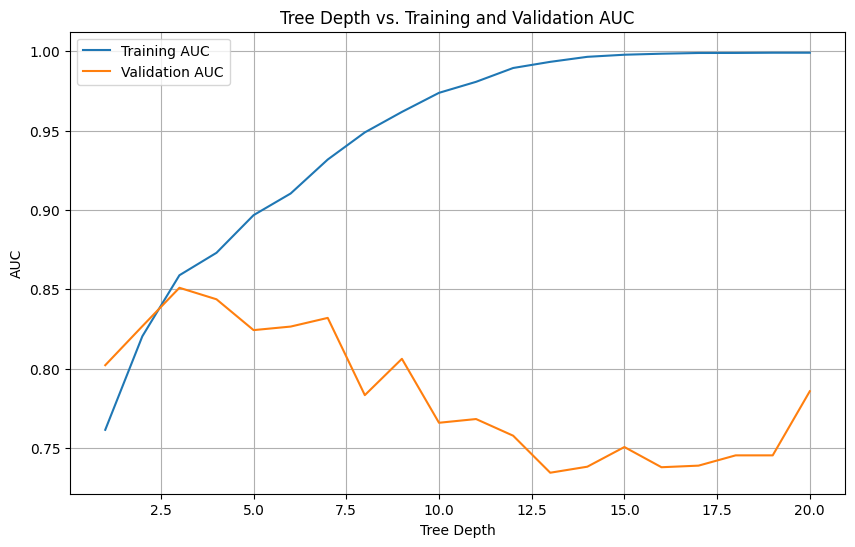

In [ ]:
# Plot tree depth vs. training and validation AUC
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_auc, label='Training AUC')
plt.plot(max_depths, val_auc, label='Validation AUC')
plt.xlabel('Tree Depth')
plt.ylabel('AUC')
plt.title('Tree Depth vs. Training and Validation AUC')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Train final model with best depth found (for example purposes using depth=5)
best_depth = 5
final_model = DecisionTreeClassifier(max_depth=best_depth)
final_model.fit(X_train, y_train)

# Access hyperparameters
max_depth_value = final_model.max_depth
min_samples_split_value = final_model.min_samples_split

# Print hyperparameter values
print("Max Depth:", max_depth_value)
print("Min Samples Split:", min_samples_split_value)


Max Depth: 5
Min Samples Split: 2


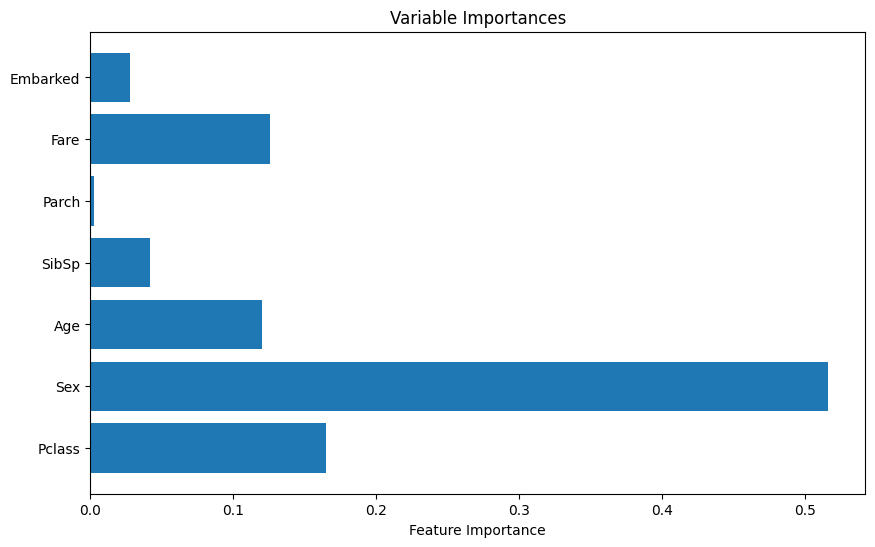

In [ ]:
# Train final model with best depth found (for example purposes using depth=5)
best_depth = 5
final_model = DecisionTreeClassifier(max_depth=best_depth)
final_model.fit(X_train, y_train)
# Plot variable importances
importances = final_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Variable Importances')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import pandas as pd

# Calculate AUC for train, validation, and test sets
train_predictions_proba = final_model.predict_proba(X_train)[:, 1]
val_predictions_proba = final_model.predict_proba(X_val)[:, 1]
test_predictions_proba = final_model.predict_proba(X_test)[:, 1]

train_auc_final = roc_auc_score(y_train, train_predictions_proba)
val_auc_final = roc_auc_score(y_val, val_predictions_proba)
test_auc_final = roc_auc_score(y_test, test_predictions_proba)

# Score on test data
test_predictions = final_model.predict(X_test)

# Function to generate confusion matrix metrics
def confusion_matrix_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return cm.flatten(), accuracy

# Calculate confusion matrix and accuracy for the test set
cm_test_flattened, accuracy_test = confusion_matrix_report(y_test.values.flatten(), test_predictions.flatten())

# Function to calculate AIR (similar to accuracy here)
def calculate_air(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

air_test = calculate_air(y_test.values.flatten(), test_predictions.flatten())

# Create a summary table
summary_table = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "AIR"],
    "Train": [train_auc_final, None, None],
    "Validation": [val_auc_final, None, None],
    "Test": [test_auc_final, accuracy_test, air_test]
})

# Print the summary table
print(summary_table)


     Metric     Train  Validation      Test
0       AUC  0.895773     0.82433  0.819393
1  Accuracy       NaN         NaN  0.768657
2       AIR       NaN         NaN  0.768657


In [ ]:
# Calculate AIR (adjusted to take both true and predicted values)
def calculate_air(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

air_test = calculate_air(y_test.values.flatten(), test_predictions.flatten())
print("AIR on Test Data:", air_test)


AIR on Test Data: 0.7686567164179104


In [ ]:
# Bias testing by demographic groups (e.g., Sex)
for group in ['Sex']:
    print(f"\nConfusion Matrices by {group}:")
    for value in Train_data[group].unique():
        # Create a mask for the test set based on group value
        mask = (X_test[group] == value)

        # Use the mask to filter y_test and predictions
        group_y_true = y_test[mask]
        group_y_pred = test_predictions[mask]

        cm_group = confusion_matrix_report(group_y_true.values.flatten(), group_y_pred.flatten())
        print(f"{group}={value}: Confusion Matrix:\n", cm_group[0], "Accuracy:", cm_group[1])



Confusion Matrices by Sex:
Sex=1: Confusion Matrix:
 [65  7 12  3] Accuracy: 0.7816091954022989
Sex=0: Confusion Matrix:
 [ 4 11  1 31] Accuracy: 0.7446808510638298


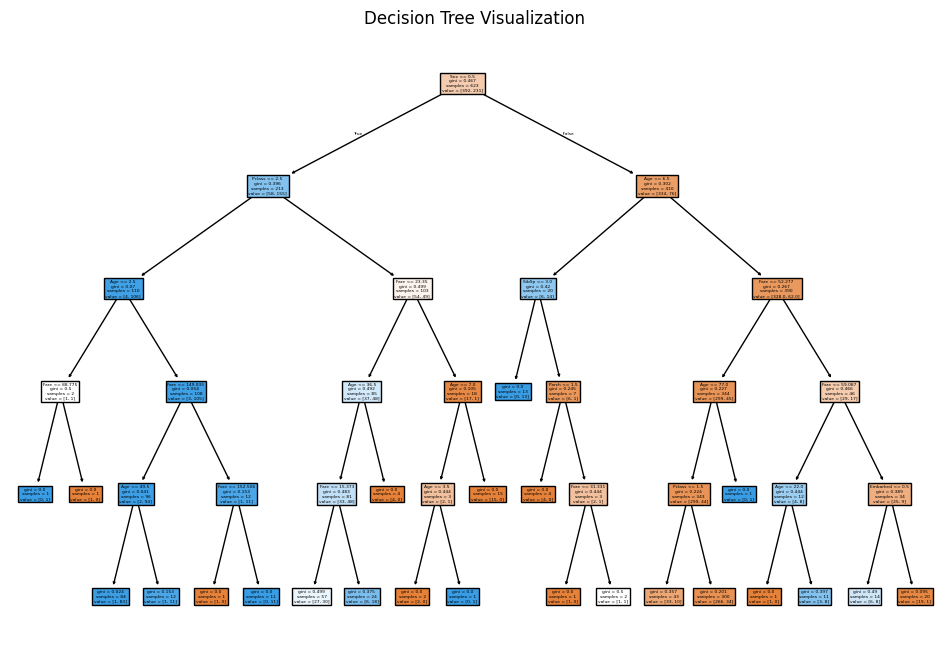

In [ ]:
# Plotting the decision tree for human interpretation
plt.figure(figsize=(12, 8))
plot_tree(final_model, feature_names=feature_names.tolist(), filled=True)
plt.title('Decision Tree Visualization')
plt.show()